In [1]:
import pandas as pd
import numpy as np
import csv

%tensorflow_version 2.x
import tensorflow as tf
tf.__version__
assert tf.__version__ >= "2.0"

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x_train = pd.read_csv('/content/drive/My Drive/bilstm_data/x_train.csv')
x_test = pd.read_csv('/content/drive/My Drive/bilstm_data/x_test.csv')
x_val = pd.read_csv('/content/drive/My Drive/bilstm_data/x_val.csv')


y_train = pd.read_csv('/content/drive/My Drive/bilstm_data/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/bilstm_data/y_test.csv')
y_val = pd.read_csv('/content/drive/My Drive/bilstm_data/y_val.csv')


In [0]:
texts = x_train['article_text'].values
texts_test = x_test['article_text'].values

In [0]:
texts_val = x_val['article_text'].values
labels_val = y_val['label'].values

In [0]:
labels_test = y_test['label'].values
labels = y_train['label'].values

In [6]:
print(labels.shape, labels_test.shape, labels_test.shape)

(5746,) (3429,) (3429,)


In [7]:
len(y_test.loc[y_test['label']==0])

3076

In [8]:
len(y_test.loc[y_test['label']==1])

353

In [0]:
MAX_NUM_WORDS = 3000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 256 # max number of words in a review to use
# done for word lengths 64, 128, 256 & 512

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_train = Tokenizer(num_words=MAX_NUM_WORDS) #convert word(string to int)
tokenizer_train.fit_on_texts(texts) 
sequences = tokenizer_train.texts_to_sequences(texts) 

word_index = tokenizer_train.word_index #convert this to dict
print('Found %s unique tokens.' % len(word_index))


Found 85423 unique tokens.


In [0]:
sequences3 = tokenizer_train.texts_to_sequences(texts_val) 
sequences_test = tokenizer_train.texts_to_sequences(texts_test)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5746, 256)
Shape of label tensor: (5746, 2)


In [13]:
data2 = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels2 = to_categorical(np.asarray(labels_test))
print('Shape of data tensor:', data2.shape)
print('Shape of label tensor:', labels2.shape)

data3 = pad_sequences(sequences3, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels3 = to_categorical(np.asarray(labels_val))
print('Shape of data tensor:', data3.shape)
print('Shape of label tensor:', labels3.shape)


Shape of data tensor: (3429, 256)
Shape of label tensor: (3429, 2)
Shape of data tensor: (639, 256)
Shape of label tensor: (639, 2)


In [0]:
x_train = data
y_train = labels

x_val = data3
y_val = labels3

x_test = data2
y_test = labels2

In [15]:
print(y_train.shape, y_val.shape, y_test.shape)

(5746, 2) (639, 2) (3429, 2)


In [16]:
GLOVE_DIR='drive/My Drive/yelp_review_polarity_csv/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [19]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed, Flatten,RepeatVector, Permute, Multiply, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import sum

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
activations = Bidirectional(LSTM(64, return_sequences=True))(x)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name='attention_vec')(attention)
attention = RepeatVector(128)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: sum(xin, axis=-2), output_shape=(64,))(sent_representation)
x = Dropout(0.5)(sent_representation)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 300)     25627200    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 128)     186880      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 256, 1)       129         bidirectional[0][0]              
______________________________________________________________________________________________

In [20]:
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], epochs=5, callbacks=[es])

Train on 5746 samples, validate on 639 samples
Epoch 1/5
5746/5746 [==============================] - 20s 4ms/sample - loss: 0.4595 - accuracy: 0.7892 - val_loss: 0.3721 - val_accuracy: 0.8419
Epoch 2/5
5746/5746 [==============================] - 13s 2ms/sample - loss: 0.3366 - accuracy: 0.8618 - val_loss: 0.2792 - val_accuracy: 0.8936
Epoch 3/5
5746/5746 [==============================] - 13s 2ms/sample - loss: 0.2993 - accuracy: 0.8771 - val_loss: 0.2606 - val_accuracy: 0.8951
Epoch 4/5
5746/5746 [==============================] - 13s 2ms/sample - loss: 0.2655 - accuracy: 0.8912 - val_loss: 0.2532 - val_accuracy: 0.9014
Epoch 5/5
5746/5746 [==============================] - 13s 2ms/sample - loss: 0.2428 - accuracy: 0.9046 - val_loss: 0.2527 - val_accuracy: 0.8967


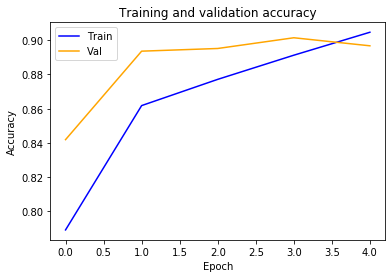

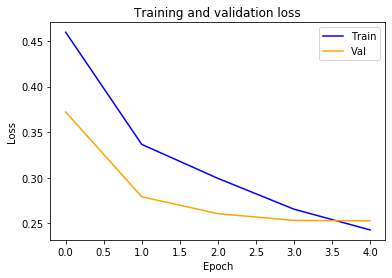

In [21]:
import matplotlib.pyplot as plt

def plot(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [22]:
y_test_new = np.argmax(y_test, axis=1)
y_test[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [23]:
y_test_new[0:5]

array([0, 0, 0, 1, 0])

In [0]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vec').output])

In [0]:
outputs = model.predict(x_test)
model_outputs = outputs[0]
attention_outputs = outputs[1]

In [26]:
model_outputs[45]

array([0.00978749, 0.9902125 ], dtype=float32)

In [27]:
attention_outputs.shape

(3429, 256)

In [28]:
len(attention_outputs[45])

256

In [29]:
len(x_test[45])

256

In [30]:
row1 = (np.array(attention_outputs[45][-216:]).reshape(1,-1))
row1.shape

(1, 216)

In [31]:
len(list(row1)[0])

216

In [32]:
col1 = list(x_test[45].reshape(1, -1)[0])
col1 = list(np.array(col1[-216:]).reshape(1, -1))[0]
len(col1)

216

In [33]:
ty = tokenizer_train.sequences_to_texts([x_test[45]])[0].split()
ty = list(ty)
ty = list(np.array(ty[-216:]).reshape(1, -1))[0]
len(ty)

216

In [0]:
my_df = pd.DataFrame(row1, columns=ty)

In [35]:
my_dummy = list(row1)[0]
smallest = min(my_dummy)
my_dummy = [(i-smallest) for i in my_dummy]
biggest = max(my_dummy)
my_dummy = [(i/biggest) for i in my_dummy]
print(my_dummy)

[0.025975293, 0.037643503, 0.0064367983, 0.010226449, 0.05435582, 0.109504476, 0.07949467, 0.06517276, 0.009178972, 0.019618465, 0.14585406, 0.32947093, 0.64313036, 0.22098058, 0.3894007, 0.17068976, 0.09997297, 0.049225103, 0.40574947, 0.15326871, 0.31549907, 0.08117431, 0.08749422, 0.26921377, 0.38784137, 0.42597383, 0.6401908, 0.56918514, 0.50130725, 0.38457185, 0.66475195, 0.4766007, 0.35836974, 0.29127535, 0.31934154, 0.23783411, 0.10473588, 0.28107598, 0.5018697, 0.5643161, 0.24092053, 0.18709554, 0.113178596, 0.07750181, 0.015866648, 0.012200947, 0.03541291, 0.05537192, 0.021327786, 0.06877938, 0.052477688, 0.10013402, 0.030953862, 0.3330084, 0.05455609, 0.04703277, 0.0007077031, 0.23522902, 0.04812665, 0.23372908, 0.26273468, 0.14370629, 0.30831093, 0.25099632, 0.09387522, 0.49945825, 0.15644062, 0.09708043, 0.048879612, 0.1775737, 0.26281664, 0.13976002, 0.19561514, 0.060578432, 0.5002376, 0.11529385, 0.14759274, 0.12357012, 0.07192312, 0.49497104, 0.207909, 0.11610492, 0.3154

In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap('RdBu')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
      color = matplotlib.colors.rgb2hex(cmap(color)[:3])
      colored_string += template.format(color, '&nbsp' + word + '&nbsp')
      
    return colored_string
    
words = tokenizer_train.sequences_to_texts([x_test[45]])[0].split()
color_array = my_dummy#np.random.rand(len(words))
s = colorize(words[0:16], color_array)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

In [37]:
s = colorize(words[0:16], color_array)
display(HTML(s))

In [38]:
s = colorize(words[37:53], color_array[37:53])
display(HTML(s))

with open('colorize.html', 'w') as f:
    f.write(s)

In [39]:
s = colorize(words[200:209], color_array[200:209])
display(HTML(s))

with open('colorize.html', 'w') as f:
    f.write(s)


In [40]:
tokenizer_train.sequences_to_texts([x_test[45]])

['on i have the of in with in the who are pro trump they respond to my here is a why do you support donald trump because god sent him to us does god of his lies don’t all politicians lie why does trump fire so many people because they are bad guys but you know it was he who appointed them without proper all of us have why did trump the meeting at the g 7 about global probably because there is no such thing as global do you know that trump appointed who is a climate change to head our environmental agency because climate changing is a do your children go to public school yes did you know that the secretary of education is not a of public schools i trust trump to do the right thing did you listen to the democrat debate it was terrible do you think the president should be why do they want to him do you research your by reading to the news no because it is fake news all of us need to be informed and to critical thinking skills a free press is necessary for the first and an is necessary for

In [0]:
with open('colorize.html', 'w') as f:
    f.write(s)

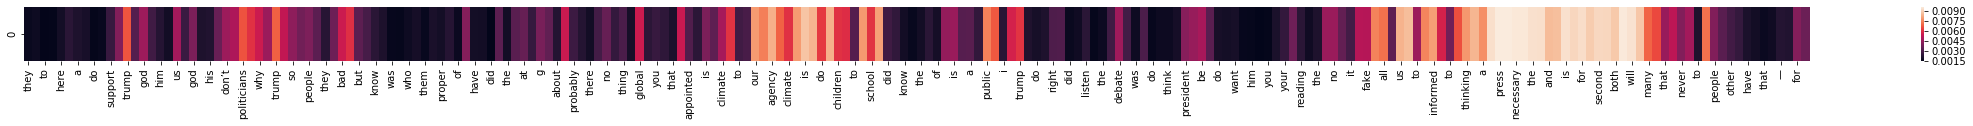

In [42]:
import seaborn as sns
plt.figure(figsize=(40, 1))
sns.heatmap(my_df)

In [43]:
op = model.predict(x_test)
prediction = op[0]
attention_wts = op[1]
prediction[0:5]

array([[0.9886381 , 0.01136188],
       [0.9396821 , 0.06031794],
       [0.9766609 , 0.02333909],
       [0.01932502, 0.9806749 ],
       [0.98609805, 0.01390197]], dtype=float32)

In [0]:
y_pred=np.argmax(prediction, axis=1)

In [45]:
np.sum(y_pred)

622

In [46]:
np.sum(y_test_new)

353

In [47]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test_new,y_pred)
print('Confusion Matrix : \n', cm1)

Confusion Matrix : 
 [[2769  307]
 [  38  315]]


In [48]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test_new, y_pred, average='macro'))
print(precision_recall_fscore_support(y_test_new, y_pred, average='weighted'))

(0.7464466417786494, 0.8962731666525453, 0.7937551484721297, None)
(0.9370453444744702, 0.8993875765529309, 0.9109666813425542, None)


In [52]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred).ravel()
pre = tp / (tp + fp)
rec = tp / (tp + fn)
tnr = tn / (tn + fp)
acc = (tp + tn)/ (tp + tn + fp + fn)
balanced_acc = (rec + tnr) / 2
f1 = 2 * (pre * rec)/(pre+rec)

print(pre, rec, tnr, acc, balanced_acc, f1)

0.5064308681672026 0.8923512747875354 0.9001950585175552 0.8993875765529309 0.8962731666525453 0.6461538461538462


In [53]:
print(tp, tn, fp, fn)

315 2769 307 38


In [54]:
import math
num = (tp*tn - fp*fn)
den = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(num, den)
mcc = num/den
print(mcc)

860569 1376882.616606078
0.6250126115479938
